In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import time
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import random

In [12]:
# import the normal data
normal = pd.read_csv('mafaulda/normal/12.288.csv', header=None)
normal = normal.iloc[:,4:7]
normal

,4,5,6
0,-0.415650,0.032459,-0.112180
1,-0.418090,0.036547,-0.110430
2,-0.430810,0.041924,-0.143310
3,-0.400170,0.041090,-0.119840
4,-0.502810,0.040474,-0.252700
...,...,...,...
249995,0.052855,-0.000624,0.033041
249996,0.106850,0.000140,0.088866
249997,0.043998,-0.000380,0.042475
249998,0.037756,0.004440,-0.000873


In [13]:
normal = normal.groupby(normal.index // 4).median()
normal

,4,5,6
0,-0.416870,0.038819,-0.116010
1,-0.431495,0.044572,-0.206780
2,-0.398305,0.047713,-0.207260
3,-0.361850,0.040279,-0.126080
4,-0.299610,0.039980,-0.081544
...,...,...,...
62495,-0.101732,-0.030026,0.009511
62496,-0.048600,-0.023524,0.028202
62497,-0.016346,-0.013369,0.059576
62498,0.068320,-0.001583,0.059699


In [14]:
scaler = StandardScaler()
normal = pd.DataFrame(scaler.fit_transform(normal))
normal.columns = np.arange(4,7)
normal

,4,5,6
0,-0.672406,1.189543,-0.625660
1,-0.694330,1.381308,-1.092792
2,-0.644575,1.486014,-1.095262
3,-0.589926,1.238205,-0.677483
4,-0.496623,1.228256,-0.448286
...,...,...,...
62495,-0.199987,-1.105032,0.020314
62496,-0.120338,-0.888353,0.116503
62497,-0.071987,-0.549863,0.277966
62498,0.054935,-0.157038,0.278594


In [15]:
# Randomly shuffle the indices
indices = np.random.permutation(normal.index)

# Split the indices into two halves
half_size = len(indices) // 2
indices_half1 = indices[:half_size]
indices_half2 = indices[half_size:]

# Create the respective halves of the DataFrames
normal1 = normal.loc[indices_half1]
normal2 = normal.loc[indices_half2]

### Making the model

In [16]:
# Function to calculate Pearson's correlation coefficient for a sliding window
def sliding_window_correlation(df, window_size):
    num_sensors = df.shape[1]
    sensor_columns = df.columns
    correlation_columns = [f'{sensor_columns[i]}_{sensor_columns[j]}_CC' for i in range(num_sensors) for j in range(i+1, num_sensors)]
    
    # Initialize a DataFrame to store correlation coefficients
    correlation_df = pd.DataFrame(index=df.index, columns=correlation_columns)
    
    # Calculate correlation coefficient for each window
    for start in range(len(df) - window_size + 1):
        end = start + window_size
        window = df.iloc[start:end]
        correlations = window.corr().values
        for i in range(num_sensors):
            for j in range(i+1, num_sensors):
                col_name = f'{sensor_columns[i]}_{sensor_columns[j]}_CC'
                correlation_df.at[end-1, col_name] = correlations[i, j]
    
    return correlation_df

# Calculate correlation coefficients using a sliding window of size 100
window_size = 100
start_time = time.time()
correlation_df = sliding_window_correlation(normal1, window_size)
end_time = time.time()

# Add the correlation columns to the original DataFrame
df_with_correlations = pd.concat([normal1, correlation_df], axis=1).dropna()
print(f"Time taken to calculate all the CC: {end_time-start_time} sec")
df_with_correlations

Time taken to calculate all the CC: 54.14598298072815 sec


,4,5,6,4_5_CC,4_6_CC,5_6_CC
20762,-0.789746,0.520692,0.090642,0.266825,0.904867,0.293605
22951,-0.787887,-1.323310,-0.857013,0.371529,0.880937,0.330874
19196,0.567712,-0.057150,0.603489,0.341514,0.845214,0.349431
11478,-0.307633,-0.268371,0.241991,0.224843,0.882729,0.209861
6007,1.311655,-1.116247,0.789143,0.371408,0.911515,0.23697
...,...,...,...,...,...,...
11279,0.630246,-0.004638,1.604116,0.300399,0.902971,0.263959
29820,0.347466,1.086653,-0.145690,0.328299,0.853624,0.133707
15751,-0.437641,1.159713,-0.200305,0.272072,0.883624,0.18967
24269,-1.817751,0.692225,-1.691618,0.48308,0.87983,0.432365


In [17]:
start_time = time.time()
window = normal1.iloc[0:window_size]
correlation = window.corr()
end_time = time.time()
print(f'Time taken to calculate the CC value for a window: {(end_time-start_time)*1000} msec')
correlation

Time taken to calculate the CC value for a window: 0.0 msec


,4,5,6
4,1.000000,0.383901,0.866980
5,0.383901,1.000000,0.305569
6,0.866980,0.305569,1.000000


### Clustering the CC data

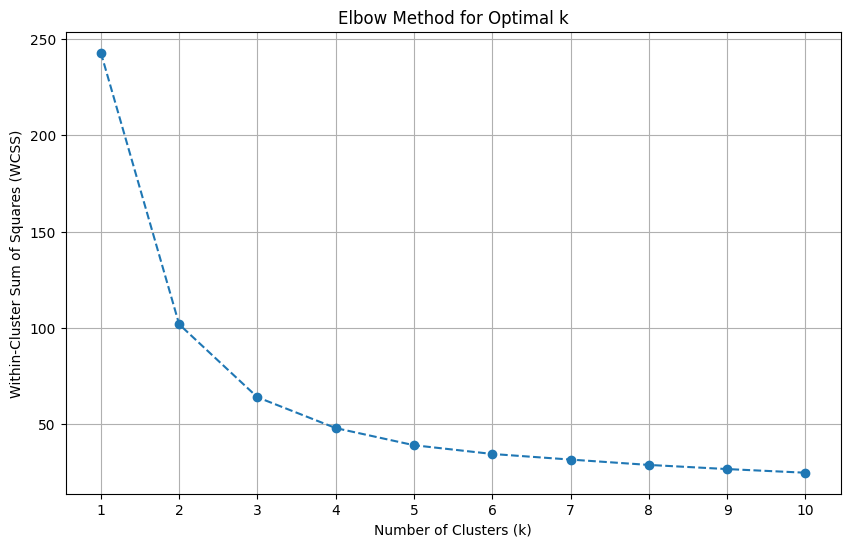

In [18]:
df_with_correlations.columns = df_with_correlations.columns.astype(str)

# Extract the CC columns
cc_columns = [col for col in df_with_correlations.columns if '_CC' in col]
cc_data = df_with_correlations[cc_columns]
cc_data.to_csv('cc_data', index=False)

# Calculate WCSS for different values of k
wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cc_data)
    wcss.append(kmeans.inertia_)

# Plot WCSS to visualize the elbow point
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [19]:
# Determine the number of clusters (for demonstration, let's use k=3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
start_time = time.time()
kmeans.fit(cc_data)
end_time = time.time()
print(f"Time taken to fit: {end_time-start_time} sec")

# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

# Assign clusters to each data point
df_with_correlations['Cluster'] = kmeans.labels_

# Display the centroids and first few rows with cluster assignment
df_with_correlations

Time taken to fit: 0.019191741943359375 sec


,4,5,6,4_5_CC,4_6_CC,5_6_CC,Cluster
20762,-0.789746,0.520692,0.090642,0.266825,0.904867,0.293605,2
22951,-0.787887,-1.323310,-0.857013,0.371529,0.880937,0.330874,2
19196,0.567712,-0.057150,0.603489,0.341514,0.845214,0.349431,2
11478,-0.307633,-0.268371,0.241991,0.224843,0.882729,0.209861,1
6007,1.311655,-1.116247,0.789143,0.371408,0.911515,0.23697,2
...,...,...,...,...,...,...,...
11279,0.630246,-0.004638,1.604116,0.300399,0.902971,0.263959,2
29820,0.347466,1.086653,-0.145690,0.328299,0.853624,0.133707,1
15751,-0.437641,1.159713,-0.200305,0.272072,0.883624,0.18967,1
24269,-1.817751,0.692225,-1.691618,0.48308,0.87983,0.432365,0


### Evaluating on the other normal data and setting threshold

In [20]:
# Calculate correlation coefficients using a sliding window of size 100
window_size = 100
start_time = time.time()
correlation_df_ = sliding_window_correlation(normal2, window_size)
end_time = time.time()

# Add the correlation columns to the original DataFrame
df_with_correlations_ = pd.concat([normal2, correlation_df_], axis=1).dropna()
print(f"Time taken to calculate all the CC: {end_time-start_time} sec")
df_with_correlations_

Time taken to calculate all the CC: 52.004685163497925 sec


,4,5,6,4_5_CC,4_6_CC,5_6_CC
29458,-1.070457,-0.059823,-1.886741,0.200197,0.907166,0.108678
25504,-1.440521,-1.047687,-1.941756,0.429417,0.904057,0.383981
21684,0.676905,0.893522,0.760710,0.392034,0.907967,0.349593
22398,-1.545622,-1.099465,-1.546569,0.3512,0.863863,0.299937
21187,-1.708842,0.292348,-0.976768,0.334333,0.837674,0.353553
...,...,...,...,...,...,...
27764,-0.094179,-1.211971,-0.970618,0.251781,0.8814,0.16206
11756,-1.065390,-1.395703,-0.316777,0.360603,0.877453,0.180498
15209,-1.206979,1.060239,-0.720661,0.420314,0.898468,0.412953
23027,-1.325721,-1.864774,-0.861155,0.350701,0.89709,0.341197


In [21]:
df_with_correlations_.columns = df_with_correlations_.columns.astype(str)

# Extract the CC columns
cc_columns = [col for col in df_with_correlations_.columns if '_CC' in col]
cc_data = df_with_correlations_[cc_columns]
cc_data

,4_5_CC,4_6_CC,5_6_CC
29458,0.200197,0.907166,0.108678
25504,0.429417,0.904057,0.383981
21684,0.392034,0.907967,0.349593
22398,0.3512,0.863863,0.299937
21187,0.334333,0.837674,0.353553
...,...,...,...
27764,0.251781,0.8814,0.16206
11756,0.360603,0.877453,0.180498
15209,0.420314,0.898468,0.412953
23027,0.350701,0.89709,0.341197


In [22]:
def calculate_distances_to_centroids(new_cc_values, centroids):
    distances = [euclidean(new_cc_values, centroid) for centroid in centroids]
    return distances

distances = []
for i in range(cc_data.shape[0]):
    col_cc = cc_data.iloc[i]
    distance = calculate_distances_to_centroids(col_cc, centroids)
    distance = np.min(distance)
    distances.append(distance)
print("Distances from new CC values to centroids:\n\n", random.sample(distances, len(distances)//1024))

Distances from new CC values to centroids:

 [0.06661949355843876, 0.06483222785182317, 0.06361860230627697, 0.03751584133555369, 0.017285349708432284, 0.03722477696200072, 0.062070540554871725, 0.039653346989158914, 0.06667430729125871, 0.05546622955237478, 0.044554129339261415, 0.05883098638236558, 0.05032336714942539, 0.041563542041134174, 0.048804441714643786]


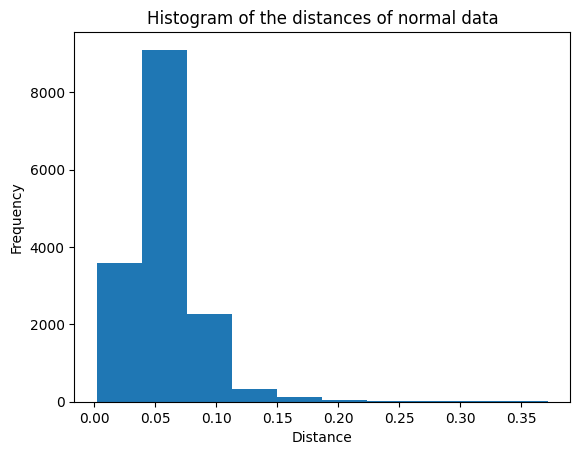

In [23]:
plt.hist(distances)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of the distances of normal data')
plt.show()

In [24]:
threshold = np.percentile(distances, 95)
print(f'Threshold: {threshold}')

Threshold: 0.10291808397758337


In [25]:
result = distances > threshold
result

array([False, False, False, ..., False, False, False])

In [26]:
TN = len(result) - np.sum(result)
print(f'True Negative: {TN}')

True Negative: 14741


In [27]:
FP = np.sum(result)
print(f'False Positive: {FP}')

False Positive: 776


### Testing on new data

In [42]:
anomalous = pd.read_csv('mafaulda/imbalance/25g/12.288.csv', header=None)
anomalous = anomalous.iloc[:,4:7]
anomalous = anomalous.groupby(anomalous.index // 4).median()
anomalous = pd.DataFrame(scaler.fit_transform(anomalous))
anomalous.columns = np.arange(4,7)
anomalous

,4,5,6
0,-0.822615,-0.481111,-0.920593
1,-0.819806,-0.430819,-0.938484
2,-0.816091,-0.368727,-0.951114
3,-0.860118,-0.558494,-0.945325
4,-0.874354,-0.627901,-0.928895
...,...,...,...
62495,0.465223,0.113689,1.686857
62496,0.475906,0.155898,1.696913
62497,0.485724,0.157210,1.712583
62498,0.497498,0.164912,1.734831


In [43]:
# Calculate correlation coefficients using a sliding window of size 100
window_size = 100
start_time = time.time()
correlation_df = sliding_window_correlation(anomalous, window_size)
end_time = time.time()

# Add the correlation columns to the original DataFrame
df_with_correlations_a = pd.concat([anomalous, correlation_df], axis=1).dropna()
print(f"Time taken to calculate all the CC: {end_time-start_time} sec")
df_with_correlations_a

Time taken to calculate all the CC: 13.86952805519104 sec


,4,5,6,4_5_CC,4_6_CC,5_6_CC
99,-1.257291,-1.458136,-1.191131,0.857419,0.906324,0.880526
100,-1.275125,-1.490460,-1.187477,0.868134,0.912486,0.879213
101,-1.294135,-1.565648,-1.214461,0.87863,0.918461,0.880687
102,-1.317920,-1.623465,-1.224488,0.889851,0.923382,0.883419
103,-1.314215,-1.553708,-1.206918,0.897732,0.928978,0.885639
...,...,...,...,...,...,...
62495,0.465223,0.113689,1.686857,0.954689,0.510637,0.257316
62496,0.475906,0.155898,1.696913,0.95542,0.523434,0.27439
62497,0.485724,0.157210,1.712583,0.956619,0.532452,0.287967
62498,0.497498,0.164912,1.734831,0.957824,0.537576,0.296353


In [44]:
df_with_correlations_a.columns = df_with_correlations_a.columns.astype(str)

# Extract the CC columns
cc_columns = [col for col in df_with_correlations_a.columns if '_CC' in col]
cc_data = df_with_correlations_a[cc_columns]
cc_data

,4_5_CC,4_6_CC,5_6_CC
99,0.857419,0.906324,0.880526
100,0.868134,0.912486,0.879213
101,0.87863,0.918461,0.880687
102,0.889851,0.923382,0.883419
103,0.897732,0.928978,0.885639
...,...,...,...
62495,0.954689,0.510637,0.257316
62496,0.95542,0.523434,0.27439
62497,0.956619,0.532452,0.287967
62498,0.957824,0.537576,0.296353


In [45]:
distances_a = []
for i in range(cc_data.shape[0]):
    col_cc = cc_data.iloc[i]
    distance_a = calculate_distances_to_centroids(col_cc, centroids)
    distance_a = np.min(distance_a)
    distances_a.append(distance_a)

In [46]:
print("Distances from new CC values to centroids:\n\n", random.sample(distances_a, len(distances_a)//1024))

Distances from new CC values to centroids:

 [0.48247636191510423, 0.40581253887267754, 0.40624691991965695, 0.48633281852629345, 0.5986538240566335, 0.4412183328763493, 0.338762969749797, 0.8524102321677474, 0.3554821746855118, 0.30962440610332764, 0.4376384603262719, 0.5151686849534642, 0.5538704851045917, 0.46733212692927567, 0.7445965526837006, 0.360460361823029, 0.41407583491434025, 0.4532853258320409, 0.5009271946513122, 0.3544357869901748, 0.5487225150670003, 0.2576757095635927, 0.1943803470597633, 0.24937788847487566, 0.7736855604703531, 0.22742646151504078, 0.33996538472313254, 0.685610159697936, 0.5125846076044871, 0.5766329422352201, 0.732342167620374, 0.593049156268737, 0.9176796486289137, 0.3336923877155257, 0.658214196377109, 0.5433513429831742, 0.9957506066484734, 0.3669930155375968, 0.546889195216032, 0.39514987675918, 0.42417967695921127, 0.6506756651201309, 0.16826676291713608, 0.2462422415569137, 0.6305498331496671, 0.6364543681573231, 0.33305899622893603, 0.59708700

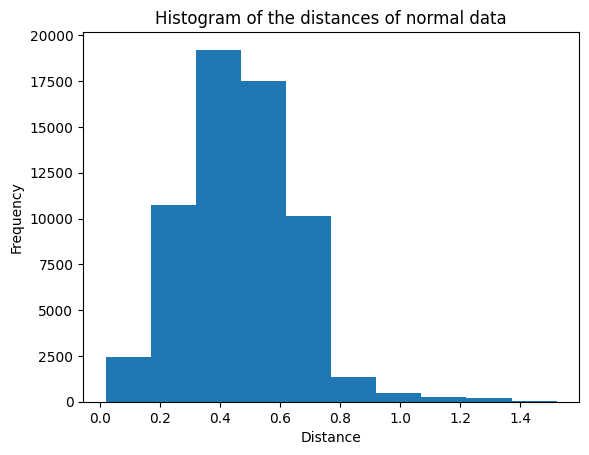

In [47]:
plt.hist(distances_a)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of the distances of normal data')
plt.show()

In [48]:
# checking the threshold
result_a = np.array(distances_a) > threshold
result_a

array([ True,  True,  True, ...,  True,  True,  True])

In [49]:
TP = result_a.sum()
print(f'True Positive: {TP}')

True Positive: 62063


In [50]:
FN = len(result_a) - result_a.sum()
print(f'False Negative: {FN}')

False Negative: 338


In [51]:
acc = ((TP + TN) / (TP + TN + FP + FN)) * 100
print(f'Accuracy: {acc}')

Accuracy: 98.57029184527323


In [52]:
prec = ((TP / (TP + FP))) * 100
print(f'Precision: {prec}')

Precision: 98.76509810786295


In [53]:
rec = ((TP / (TP + FN))) * 100
print(f'Recall: {rec}')

Recall: 99.45834201374979


In [54]:
f1 = ((2 * rec * prec) / (rec + prec))
print(f'F1 Score: {f1}')

F1 Score: 99.11050782497605
